# Ejercicios Segunda Parte. Física de Redes Complejas y Aplicaciones Interdisciplinares.
#### Carlos J. Ramos Salas.
En este notebook corresponde al informe a la actividad a entregar en la segunda parte de este curso, en el cual se busca replicar algunos resultados presentados en el artículo: Johnson, S., Domínguez-García, V., Donetti, L., & Muñoz, M. A. (2014). Trophic coherence
determines food-web stability. Proceedings of the National Academy of Sciences, 111(50), 17923-17928. En el cual se estudia el modelo de depredación preferente en una red trófica. Este notebook junto al correspondiente a los ejercicios de la parte anterior puede ser encontrado en el repositorio de [GitHub asociado](https://github.com/ashybabashyba/RedesComplejasUGR) (https://github.com/ashybabashyba/RedesComplejasUGR).

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random 

### 1. Introducción.

Las redes tróficas son una representación gráfica que permite obtener información sobre los predadores y depredadores de un ecosistema junto con las interacciones de cual especie alimenta a otra. Una red trófica puede ser modelada a través de un grafo dirigido, donde la dirección de cada arista indica cual es el depredador de la especie.

Existen diversos modelos que tienen el fin de modelar la creación de una red trófica en un ecosistema según el número de especies o posible número de presas y usando generación de grafos aleatorios, por ejemplo, el modelo de cascada que tuvo que ser generalizado en un futuro con el fin de poder incluir una posibilidad de canibalismo (ya que este permite aumentar la coherencia de las redes). Otro ejemplo es el modelo de nichos que introduce un intervalo a cada especie de donde se puede alimentar, lo cual coincide más con los fenómenos observados en la naturaleza.

El modelo que estudiaremos y modelaremos computacionalmente en este proyecto es el modelo de depredación preferente, en el cual, se trata de reproducir de manera similar la intervalidad del modelo de nichos y permite casos de canibalismo como el modelo de cascada generalizados, para ello, se tiene en consideración los niveles tróficos de cada especie y se asume que un depredador tiende a elegir presas que tengan niveles tróficos similares (de allí el nombre preferente). A continuación se presenta las ecuaciones y parámetros que rigen al sistema junto al código construido para replicar la creación del sistema.

### 2. Modelo computacional.

Se busca reproducir la figura 2(b) del artículo de referencia, en el cual se representa el parámetro de incoherencia $(q)$ en términos de la temperatura $(T)$ para una red trófica modelada por depredación preferente con un total de $77$ especies, de las cuales $40$ son basales y un total de $181$ enlaces.

Para armar la red comenzamos asignando todas las especies basales en el primer nivel trófico $l = 1$, luego añadimos uno a uno cada especie no basal, por cada uno de ellos calculamos un número aleatorio, distribuido a partir de un distribución $\beta$ con el fin de determinar el número total de presas ($k_i$) teniendo en cuenta a $s_i$ (conjunto de las especies existentes antes de añadir la especie $i$-ésima), así, $k_i = x s_i$ con
\begin{equation*}
    x \in f(x; \ 1, \beta) = \beta (1-x')^{\beta - 1}; \ \ \ \ \text{con } \beta = \dfrac{S^2 - B^2}{2L}-1.
\end{equation*}
 Una vez teniendo esto, se añade el nodo $i$-ésimo y en caso donde $k_i \neq 0$, se escoge una primera presa aleatoria en $s_i$, sin pérdida de generalidad digamos que es el nodo $j$-ésimo, luego a partir de aquí se van pasando por los nodos restantes de $s_i$ y con una probabilidad proporcional a $exp(-|l_j - l_m|/T)$ se crea un enlace o no hasta haber pasado por todos los nodos o haber creado la cantidad de enlaces correspondientes según el número de presas; finalmente, se calcula el nivel trófico de la especie $i$ como sigue
\begin{equation}
    l_i = \dfrac{1}{k_i} \sum_j a_{ij}l_j + 1,
\end{equation}
en donde $a_{ij}$ es igual a $1$ si existe conexión de $i$ dirigida a $j$ y cero en caso contrario. Este proceso se repite con cada especie hasta haber añadido todo el resto de especies no basales y tener representado en un grafo dirigido las especies totales y el nivel trófico de cada uno con sus respectivas presas, computacionalmente se construye como se muestra a continuación.

In [69]:
def generacionRedTrofica(T_var):
    # Parámetros característicos de la red trófica
    S = 77
    B = 40
    L = 181
    beta = (S**2 - B**2)/(2*L) - 1
    T = T_var

    # Creación del grafo dirigido que representa a la red
    G = nx.DiGraph()

    # Ciclo for para añadir las especies basales con nivel trófico igual a 1
    for i in range(1, B+1):
        G.add_node(f"Especie Basal {i}", level=1)

    # Ciclo for para calcular las conexiones del nuevo depredador y añadir ese nodo con su respectivo nivel trófico
    for i in range(B+1, S+1):
        x = (1 - (1 - random.uniform(0, 1))**(1 / beta))         # El número aleatorio no considera ni a 1 ni 0
        k = np.floor(x*len(G.nodes()))
        # print(k)

        # Selección aleatoria de una primera presa
        random_node = random.choice(list(G.nodes()))
        G.add_node(f"Especie no Basal {i}", level=G.nodes[random_node]['level'] + 1)
        G.add_edge(random_node, f"Especie no Basal {i}")

        
        # Calculo de la normalizacion de la probabilidad
        norm_p = 0
        for node in G.nodes():
            if node != f"Especie no Basal {i}":
                norm_p += np.exp(-np.abs(G.nodes[random_node]['level'] - G.nodes[node]['level'])/T)
        
        # Generación del resto de presas
        k_in = G.in_degree(f"Especie no Basal {i}")
        l_i = G.nodes[random_node]['level']
        l = l_i

        # En este ciclo for se añade el resto de presas, idealmente debería haber un while(k_in < k) antes para tener exacto la cantidad de presas
        # que se generan aleatoriamente, sin embargo esto aumenta considerablemente el coste computacional, por lo que es omitido.
        while(k_in < k):
            for node in G.nodes():
                if not G.has_edge(node, f"Especie no Basal {i}"):
                    l_m = G.nodes[node]['level']

                    p = np.exp(-np.abs(l_i - l_m)/T)/norm_p

                    if p > random.uniform(0, 1):
                        G.add_edge(node, f"Especie no Basal {i}")
                        l += l_m
                        k_in += 1

                    if k_in >= k:
                        break

        # Actualizacion de niveles tróficos del nodo estudiado
        l = 1 + l/k_in
        G.nodes[f"Especie no Basal {i}"]['level'] = l


    # Cálculo del parametro de incoherencia
    adj_matrix  = nx.adjacency_matrix(G).todense().T
    trophic_lvl = [G.nodes[node]['level'] for node in G.nodes()]
    # print(np.sum(adj_matrix))
    l_1 = 0
    l_2 = 0

    # print(adj_matrix)
    # print(trophic_lvl)

    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            l_2 += (trophic_lvl[i] - trophic_lvl[j])**2*adj_matrix[i,j]
            l_1 += (trophic_lvl[i] - trophic_lvl[j])*adj_matrix[i,j]
    l_1 = l_1/np.sum(adj_matrix) 
    l_2 = l_2/np.sum(adj_matrix)
    q = np.sqrt(l_2 - 1)
    # print("q = ", q, "- T = ", T)
    # print("l_1 =", l_1) 
            
    ## Print a consola de todos los nodos con sus respectivos niveles tróficos en caso de querer comparar
    # for nodo in G.nodes():
    #     print("Nodo:", nodo, "- Nivel trófico:", G.nodes[nodo]['level'])

    return q, G

q, G = generacionRedTrofica(0.1)

En este código primero se inicializan los parámetros de la red $S, N, L, T$; luego de ello generamos un grafo dirigido vacío donde iremos almacenando la información de los nodos/especies y sus respectivos niveles tróficos. Por cada especie basal i, añadimos un nodo que guardamos con el nombre "Especie Basal $i$" y le asignamos un nivel trófico igual a $1$ (que guardamos con la característica denominado "level").

Iniciamos luego un ciclo for para las especies no basales, escogemos primero un nodo de manera aleatoria de aquellos que ya han sido agregados previamente al grafo G utilizando la función "random.choice", creamos entonces un nuevo nodo que llamamos "Especie no Basal $i$" y creamos una conexión entre este nodo y el escogido aleatoriamente, luego, le asignamos a la especie no basal un nivel trófico auxiliar igual al nivel trófico del nodo aleatorio más $1$, esto con el fin de poder utilizar luego el mismo nodo consigo mismo para generar conexiones y poder modelar fenómenos como canibalismo. Se genera el número aleatorio de presas adicionalmente y creamos luego un bucle "while" para crear conexiones hasta que la especie no basal $i$ tenga un número de presas igual al número aleatorio (siguiendo el proceso descrito en el párrafo anterior al código), con esto finalmente actualizamos también el nivel trófico de la especie en la que estamos iterando y lo realizamos hasta que nuestra red tenga el número de nodos deseados.

Este proceso descrito anteriormente ya de por si construye toda la red trófica a estudiar y lo almacena en el grafo dirigido G, fuera de estos ciclos finalmente se hace un post procesamiento donde usando los datos de G y los niveles tróficos se calculan los valores esperados $\langle l \rangle$ y $\langle l^2 \rangle$ junto con el parámetro de incoherencia $q$ como sigue

\begin{align}
    \langle l \rangle &= \dfrac{1}{L} \sum_{ij} a_{ij} (l_i - l_j), \\
    \langle l^2 \rangle &= \dfrac{1}{L} \sum_{ij} a_{ij} (l_i - l_j)^2, \\
    q &= \sqrt{\langle l^2 \rangle - 1}.
\end{align}

Para facilidad de exportación de resultados y no volver a repetir código en la siguiente sección, se convierte toda esta rutina en una función que devuelve tanto el grafo G como el valor de q. 

### 3. Reproducción de resultados.

Con la rutina para calcular $q$ establecida, ya se puede replicar el resultado de la figura 2b como solicita el ejercicio, en este caso hay que tener en cuenta que al realizarse procesos probabilísticos, será necesario para cada temperatura realizar varias mediciones para poder promediar el valor de $q$ y adicionalmente poder calcular la desviación estándar de las mismas (usando en este caso una función de numpy), luego de realizar estos procesos estadísticos, es necesario replicarlo para cada temperatura a medir, de esta manera tenemos entonces el siguiente código.

In [41]:
# Valores de temperatura en los que se calculan q y números de pasos para estadística
T_values = [0.15, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50]
N = 100
q_mean = []
q_std = []

for T in T_values:
    q_values = []

    for _ in range(N):
        q, G = generacionRedTrofica(T)
        q_values.append(q)

    q_mean.append(np.mean(q_values))
    q_std.append(np.std(q_values))
    print("Terminado ciclo T= ", T)


print(q_mean)
print(q_std)

Terminado ciclo T=  0.15
Terminado ciclo T=  0.25
Terminado ciclo T=  0.5
Terminado ciclo T=  0.75
Terminado ciclo T=  1.0
Terminado ciclo T=  1.25
Terminado ciclo T=  1.5
Terminado ciclo T=  1.75
Terminado ciclo T=  2.0
Terminado ciclo T=  2.25
Terminado ciclo T=  2.5
[0.12371057589971043, 0.1782962932659817, 0.31007659465293197, 0.3665029021103703, 0.40345123180938564, 0.4327589709574849, 0.43017168722228805, 0.4434339065470044, 0.4604907024068315, 0.449538899799516, 0.46492357281152785]
[0.0913665892438852, 0.07109973545344, 0.0587022385768371, 0.06340088139960791, 0.05407919646794186, 0.059073779739827185, 0.05345706790242693, 0.05118149229186999, 0.058436332641839644, 0.057233384774850474, 0.04965766919895508]


Dado que el código anterior es bastante ineficiente en python para $N$ muy grandes (y además que empeora el rendimiento si $T$ toma valores cercanos al $0$), se optó por separarlo para extraer los datos de $\overline{q}$ y su respectiva desviación estándar para cada temperatura y reproducir la gráfica en este código de abajo donde insertamos los datos de entrada.

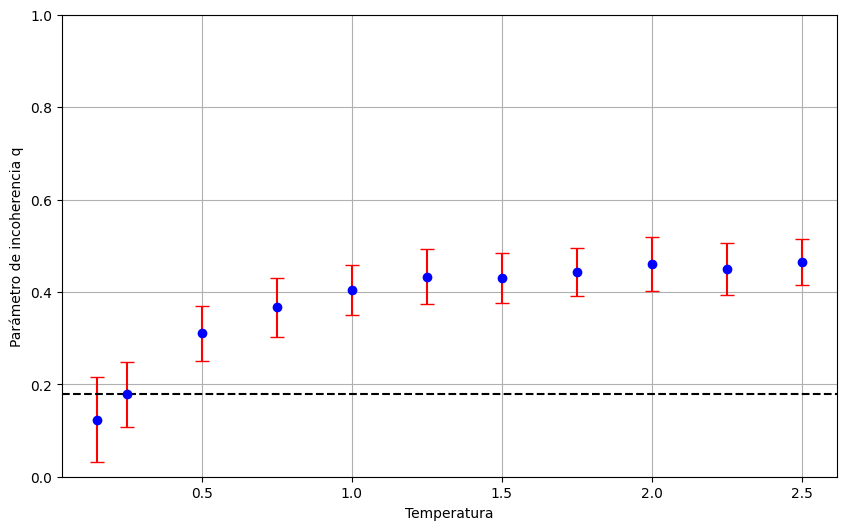

In [45]:
# Datos de entrada, T, q_mean, q_std (Si se ejecutó la anterior celda, los datos quedan almacenados)
T_values = [0.15, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50]
q_mean = [0.12371057589971043, 0.1782962932659817, 0.31007659465293197, 0.3665029021103703, 0.40345123180938564, 0.4327589709574849, 0.43017168722228805, 0.4434339065470044, 0.4604907024068315, 0.449538899799516, 0.46492357281152785]
q_std = [0.0913665892438852, 0.07109973545344, 0.0587022385768371, 0.06340088139960791, 0.05407919646794186, 0.059073779739827185, 0.05345706790242693, 0.05118149229186999, 0.058436332641839644, 0.057233384774850474, 0.04965766919895508]

plt.figure(figsize=(10, 6))
plt.errorbar(T_values, q_mean, yerr=q_std, fmt='o', color='b', ecolor='r', capsize=5)
plt.axhline(y=0.18, color='black', linestyle='--')
plt.xlabel('Temperatura')
plt.ylabel('Parámetro de incoherencia q')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

Finalmente, utilizando ahora el grafo que retoma la función, podemos utilizar la librería de networkx junto a matplotlib para así representar el grafo a pesar de no poder organizarlo según su nivel trófico como se muestra a continuación.

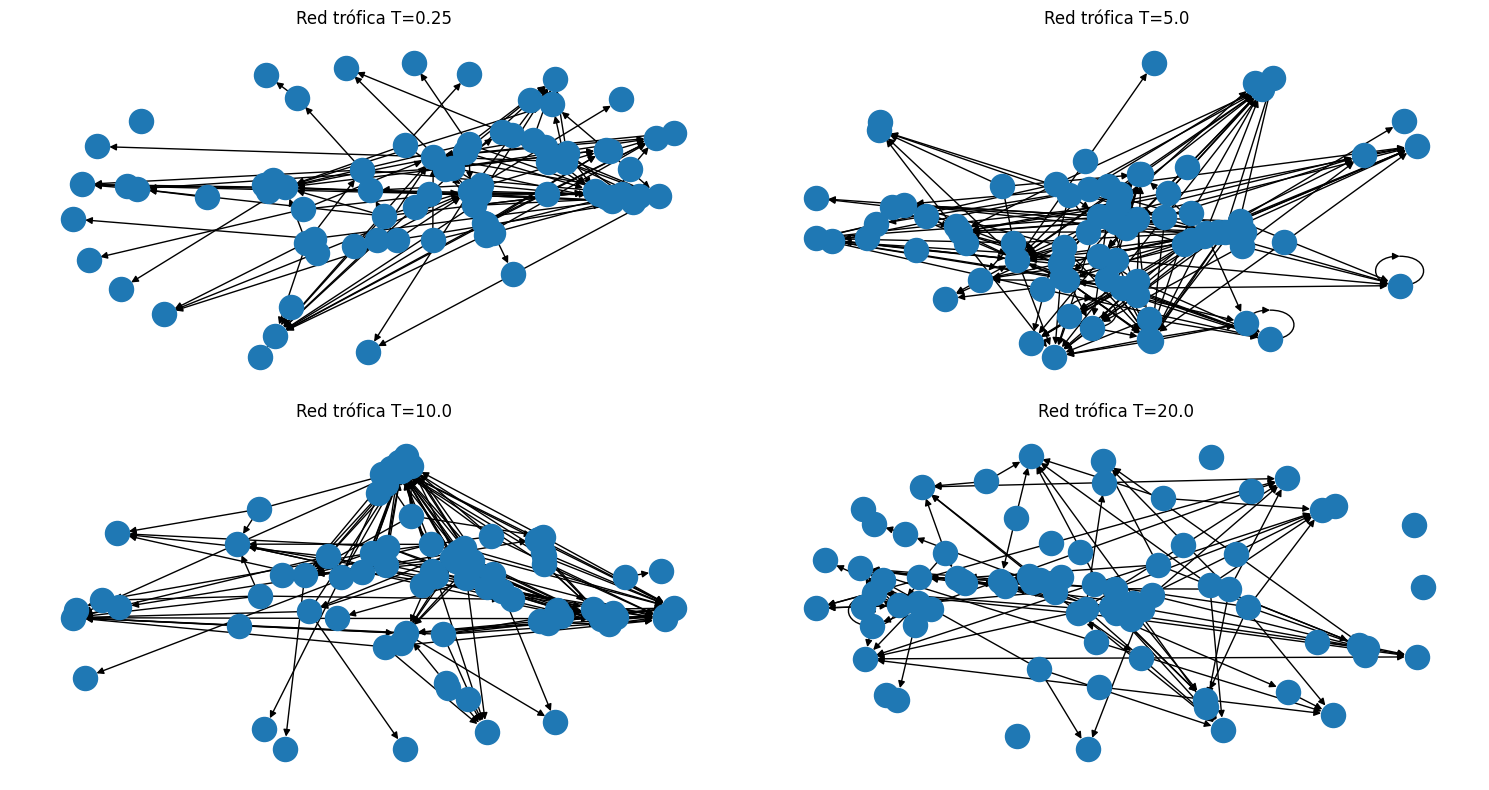

In [83]:
T_values = [0.25,  5.00,  10.00, 20.00]


plt.figure(figsize=(15, 8))
for i, T in enumerate(T_values, 1):
    q, G = generacionRedTrofica(T)
    plt.subplot(2, int(len(T_values)/2), i)
    nx.draw_spring(G)
    plt.title(f"Red trófica T={T}")

plt.tight_layout()
plt.show()

Dado que existen limitaciones en la visualización de las redes, se opta por presentar los resultados a través de histogramas que muestren la cantidad de nodos con niveles tróficos en intervalos del estilo $(n, n+1)$, con $n \in \mathbb{N}$, tal como se muestra en el código próximo. Podemos observar que a temperaturas cercanas al cero existen posibilidades de obtener nodos con niveles tróficos cercanos a $6$, mientras que existe una clara separación entre los diferentes tipos de niveles tróficos. Por otro lado, para temperaturas muy altas casi todos los nodos tienen los mismos niveles tróficos en estos casos, estando cercanos a valores entre $1$ y $4$ mostrando que realmente se comporta como una especie de red aleatoria con probabilidad uniforme.

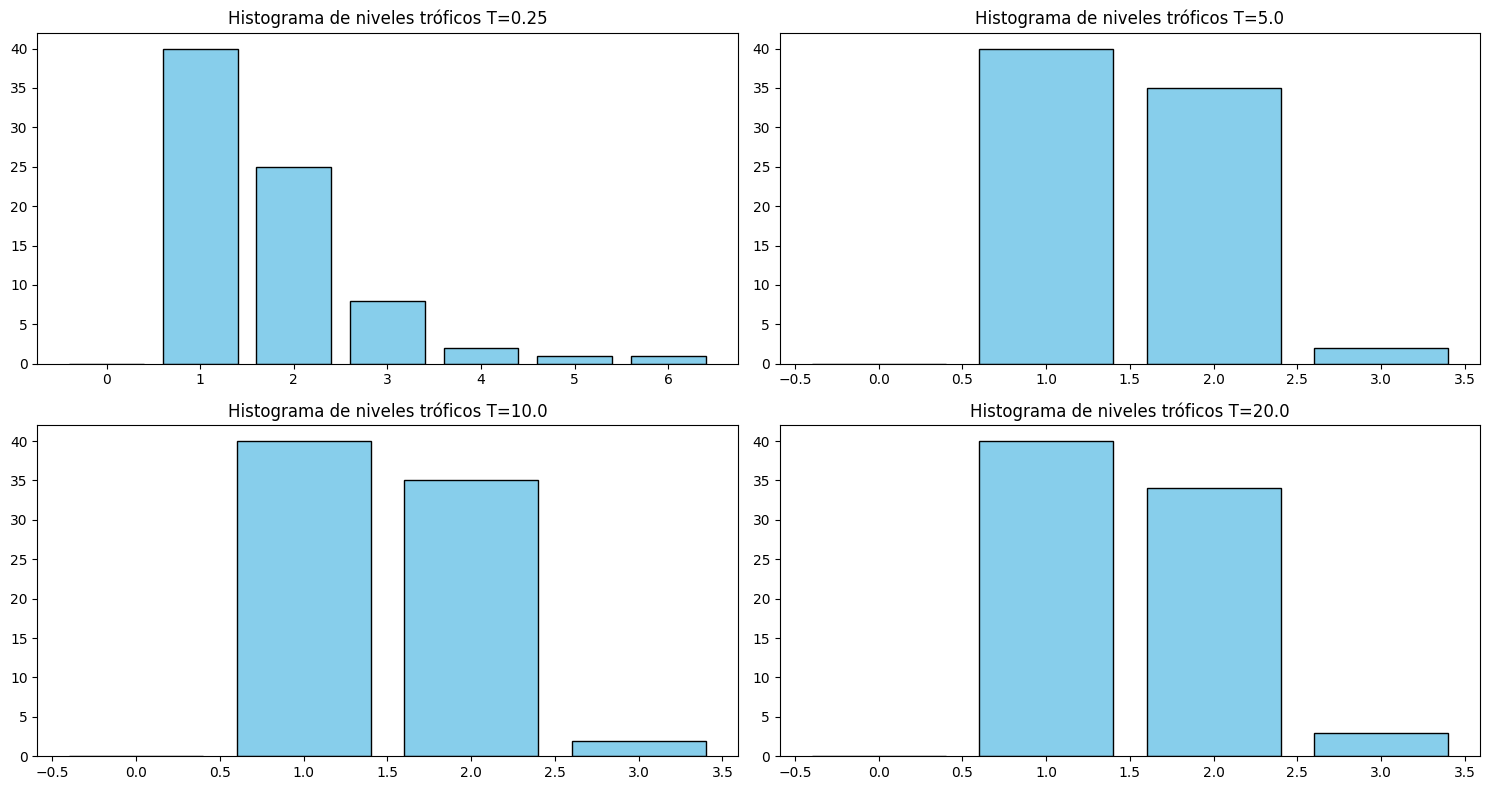

In [84]:
T_values = [0.25,  5.00,  10.00, 20.00]


plt.figure(figsize=(15, 8))
for i, T in enumerate(T_values, 1):
    q, G = generacionRedTrofica(T)

    k_vec = [G.nodes[node]['level'] for node in G.nodes()]
    k = int(np.floor(max(k_vec))+1)
    bins = np.arange(k + 1)
    hist, _ = np.histogram(k_vec, bins=bins)

    plt.subplot(2, int(len(T_values)/2), i)
    plt.bar(bins[:-1], hist, width=0.8, align='center', color='skyblue', edgecolor='black')
    plt.title(f"Histograma de niveles tróficos T={T}")

plt.tight_layout()
plt.show()